# Some Plotting of the predictions obtained with Linear

In [8]:
import os 

import urllib.request

import pickle
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'

# Dati Aggiornati giorno per giorno
if not os.path.exists('data'):
    os.mkdir('data')
urllib.request.urlretrieve(DATA_URL, DATA_FILE)

# Load historical data from local file
df_full = pd.read_csv(DATA_FILE, 
                 parse_dates=['Date'],
                 encoding='ISO-8859-1',
                 dtype={'RegionName': str,
                        'RegionCode': str},
                 error_bad_lines=False)

# For testing, restrict training data to that before a hypothetical predictor submission date
# Restringe il training-testing al 31 luglio 2020, data IPOTETICA di consegna del modello
# Nel nostro caso sarà 2020-12-22
HYPOTHETICAL_SUBMISSION_DATE = np.datetime64('2020-07-31')
df = df_full[df_full.Date <= HYPOTHETICAL_SUBMISSION_DATE]

# Add RegionID column that combines CountryName and RegionName for easier manipulation of data
df['GeoID'] = df['CountryName'] + '__' + df['RegionName'].astype(str)
df_full['GeoID'] = df_full['CountryName'] + '__' + df_full['RegionName'].astype(str)

# Add new cases column
df['NewCases'] = df.groupby('GeoID').ConfirmedCases.diff().fillna(0)
df_full['NewCases'] = df_full.groupby('GeoID').ConfirmedCases.diff().fillna(0)

# Keep only columns of interest
id_cols = ['CountryName',
           'RegionName',
           'GeoID',
           'Date']

cases_col = ['NewCases']

npi_cols = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']

df_full = df_full[id_cols + cases_col + npi_cols]
df = df[id_cols + cases_col + npi_cols]

# Fill any missing case values by interpolation and setting NaNs to 0
df.update(df.groupby('GeoID').NewCases.apply(
    lambda group: group.interpolate()).fillna(0))
df_full.update(df_full.groupby('GeoID').NewCases.apply(
    lambda group: group.interpolate()).fillna(0))

# Fill any missing NPIs by assuming they are the same as previous day
for npi_col in npi_cols:
    df.update(df.groupby('GeoID')[npi_col].ffill().fillna(0))
    df_full.update(df_full.groupby('GeoID')[npi_col].ffill().fillna(0))

/home/mattia/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/mattia/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


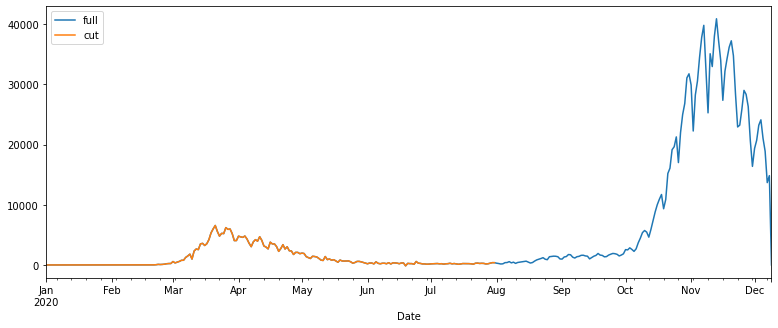

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))

geo = 'Italy__nan'  # nan, dato che Italy non ha sotto-regioni

for data, label in zip([df_full, df], ['full', 'cut']):
  data[data.GeoID == geo].plot(y='NewCases', x='Date', ax=ax, label=label)

# Sono perfettamente sovrapposti fino a fine luglio, Dopodichè tengo solo quello intero.

In [12]:
# Ora vorrei fare la stessa cosa del plot precedente, con la prediction del modello lineare

MODEL_FILE = os.path.join('models', 'model.pkl')

# Load model
with open(MODEL_FILE, 'rb') as model_file:
  model = pickle.load(model_file)

In [29]:
# Siccome li ho già predetti nell'altro notebook, carichiamo le previsioni per i 30 giorni di agosto

pred = pd.read_csv(os.path.join('predictions', 'try_1_month.csv'))

pred[pred.CountryName == 'Italy']

pred.Date = pd.to_datetime(pred.Date)


<AxesSubplot:xlabel='Date'>

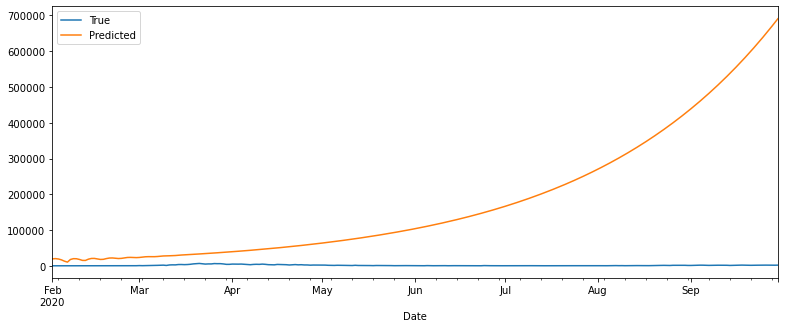

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(13, 5))

geo = 'Italy__nan'  # nan, dato che Italy non ha sotto-regioni


start_date = '2020-02-01'
end_date = '2020-09-30'

country = 'Italy'

date_mask = (df_full.Date <= end_date) & (df_full.Date >= start_date)
date_mask2 = (pred.Date <= end_date) & (pred.Date >= start_date)

country_mask = df_full.CountryName == country
country_mask2 = pred.CountryName == country

true = df_full[country_mask & date_mask]
predicted = pred[country_mask2 & date_mask2]

true.plot(y='NewCases', x='Date', ax=ax, label='True')
predicted.plot(y='PredictedDailyNewCases', x='Date', label='Predicted', ax=ax)
